# TP4 : Descente de gradient et débruitage d'une image en niveaux de gris

Le but de ce TP est de comprendre comment mettre au point un **modèle variationnel** de débruitage, c'est-à-dire ramener la problématique de débruiter une image à un problème de minimisation. L'idée essentielle étant de trouver une quantité (une fonction $J$ qui prend une image en argument, à valeurs dans $\mathbb{R}$) qui permette de distinguer une image comportant du bruit d'une image "propre" : 

$$
J ( \text{image propre} ) << J(\text{image bruitée}) \: .
$$

On utilisera ensuite l'algorithme de **descente de gradient** afin de résoudre le problème de minimisation posé. 


On commence par charger une image couleurs de taille 256 par 256 pixels ici, on récupère ici un `np.ndarray`, les deux premières dimensions ($256$, $256$) sont le nombre de pixels dans la hauteur et dans la largeur de l'image. La dernière dimension permet de stocker les 3 canaux couleurs R, V, B et éventuellement un quatrième canal "alpha" (transparence, perçu lorsque l'image est superposée à une autre image) qu'on laissera ici de côté.

<class 'numpy.ndarray'> (256, 256, 4)


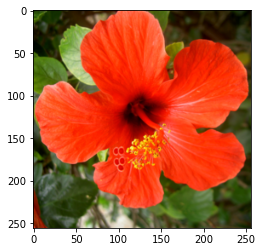

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as mpimg

name = 'hibiscus256.bmp'
img0 = mpimg.imread(name)
plt.imshow(img0)

n,N,a = img0.shape # n : nb de lignes et N : nb de colonnes
print(type(img0), img0.shape)

On se place au niveau de la ligne de pixel $50$ et on représente la variation de chacun des trois canaux de couleurs, notés `Sr`, `Sv` et `Sb`, le long de cette ligne. On les renormalise par $255$ afin de ramener le tracé entre $0$ et $1$. La moyenne de ces trois canaux nous donnera le niveau de gris, c'est le `np.array` de taille `N = 256` noté `S` par la suite.

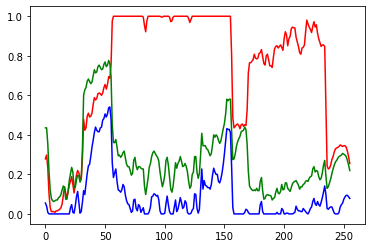

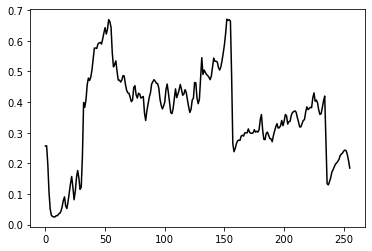

In [2]:
Sr = img0[50,:,0]/255
Sv = img0[50,:,1]/255
Sb = img0[50,:,2]/255
S = (Sr + Sv + Sb)/3
plt.figure()
plt.plot(Sr, 'red')
plt.plot(Sv, 'green')
plt.plot(Sb, 'blue')
plt.figure()
plt.plot(S, 'black')

On va maintenant "bruiter" le signal $S$ : on considère un échantillon de $N$ variables aléatoires iid selon la loi normale $\mathcal{N} (0,\sigma^2)$ centrée de variance $\sigma^2$, on prendra ici $\sigma = 0.1$, on rappelle que le signal $S$ varie entre $0$ et $1$. On obtient une réalisation de cet échantillon par un appel à la fonction `np.random.normal(0,0.1,N)`, on vient ajouter cette réalisation à `S`, on appellera `Snoise` le signal bruité ainsi créé.

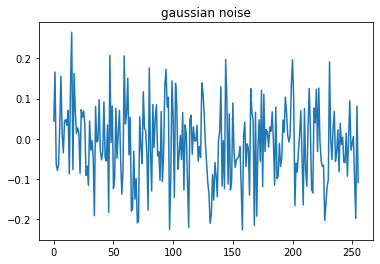

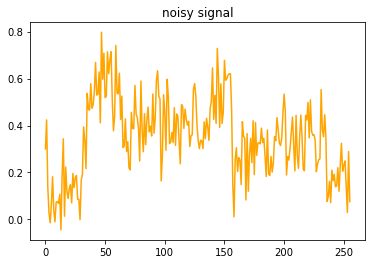

In [3]:
noise = np.random.normal(0, 0.1, N)
Snoise = S + noise

plt.figure()
plt.title('gaussian noise')
plt.plot(noise)
plt.figure()
plt.title('noisy signal')
plt.plot(Snoise, 'orange')

## Exercice 1.- Un modèle variationnel pour débruiter un signal 1D

On se donne $v : [0,1] \rightarrow \mathbb{R}$ qu'on suppose être une version bruitée (penser à $S_{noise}$) de $u : [0,1] \rightarrow \mathbb{R}$ (penser à $S$) qu'on ne connaît pas et qu'on souhaiterait "retrouver". Pour cela, on va essayer de différencier (de façon quantitative) un signal bruité d'un signal non bruité : on observe que le signal bruité oscille beaucoup, sa dérivée (si le signal $v$ est dérivable) est grande en valeur absolue et par exemple pour $q \geq 1$,
$$
\| v^\prime \|_{q} = \left( \int_{[0,1]} | v^\prime |^q \right)^\frac{1}{q} \quad \text{sera plus grand pour } v \text{ que pour } u \: . 
$$
Du point de vue du signal discret, on peut remplacer la dérivée par le taux de variation entre deux valeurs successives : supposons qu'on connaît
$$
V = \left[ v(x_0) , v(x_1), \ldots, v(x_{N-1}) \right] \in \mathbb{R}^N \quad \text{avec} \quad x_k = k h , \quad h = \frac{1}{N-1}
$$
on peut définir
$$
\delta V = \left[ v(x_1) - v(x_0), v(x_2) - v(x_1) , \ldots, v(x_{N-1}) - v(x_{N-2}) \right] = \left[ V_1 - V_0, V_2 - V_1, \ldots, V_{N-1} - V_{N-2} \right] \in \mathbb{R}^{N-1}
$$
ou encore
$$
\delta_h V = \frac{\delta V}{h} = \left[ \frac{v(x_1) - v(x_0)}{h}, \frac{v(x_2) - v(x_1)}{h} , \ldots, \frac{v(x_{N-1}) - v(x_{N-2})}{h} \right] \: .
$$
De même que pour le signal continu, on peut alors définir
$$
\left\| \delta_h V \right\|_q = \frac{1}{h} \| \delta V \|_q = \frac{1}{h} \left( \sum_{k=0}^{N-2} | (\delta V)_k |^q \right)^\frac{1}{q} \quad \text{où} \quad \| \cdot \|_q \text{ désigne la norme } q \text{ dans } \mathbb{R}^{N-1} \: .
$$

1. Reprendre les vecteurs `S` et `Snoise` et représenter sur une même figure $\| \delta S \|_q$ et $\| \delta S_{noise} \|_q$ en fonction de $q$, pour $q \in $ `np.arange(1,8,0.2)` par exemple.

*Indication : on pourra définir une fonction `delta` qui prend en argument un `np.array V` et renvoie le `np.array` $\delta V$ et utiliser ensuite la fonction `np.linalg.norm`.*

2. On observe que pour $1 \leq q \leq 2$ au moins, comme attendu, $\| \delta S \|_q << \| \delta S_{noise} \|_q$. Afin de confirmer cette observation, on réalise $m$ fois cette expérience : pour cela on appelle $m$ fois la fonction `np.random.normal(0, 0.1, N)` et on obtient $m$ versions bruitées de `S` : 
$S_{noise}^{(1)}, \ldots, S_{noise}^{(m)}$.
Compléter le script ci-dessous afin de représenter sur une deuxième figure
$$
\min_{1 \leq k \leq m} \| \delta S_{noise}^{(k)} \|_q \quad \text{et} \quad \max_{1 \leq k \leq m} \| \delta S_{noise}^{(k)} \|_q 
$$
en fonction de $q$ pour les valeurs de $q \in $ `np.arange(1,8,0.2)` précédentes.

In [4]:
"""
m = 100
for k in range(m):
    noise = np.random.normal(0, 0.1, N) 
    Snoise = S + noise
"""

'\nm = 100\nfor k in range(m):\n    noise = np.random.normal(0, 0.1, N) \n    Snoise = S + noise\n'

3. Cela confirme que pour $1 \leq q \leq 2$, pour tout $k = 1, \ldots, m$, $\| \delta S \|_q << \| \delta S_{noise}^{(k)} \|_q$. Modifier votre script (ci-dessus) afin de représenter sur une deuxième figure $\| \delta \cdot \|_q^q$ à la place de $\| \delta \cdot \|_q$, i.e. représenter
$$
\min_{1 \leq k \leq m} \| \delta S_{noise}^{(k)} \|_q^q \quad \text{et} \quad \max_{1 \leq k \leq m} \| \delta S_{noise}^{(k)} \|_q^q 
$$
en fonction de $q$ pour les valeurs de $q \in $ `np.arange(1,8,0.2)` précédentes.


On peut finalement considérer $\| \delta \cdot \|_q^q$ afin de distinguer un signal bruité $S_{noise}$ du signal non bruité $S$. Afin d'essayer de retrouver $S$,
on va donc chercher à retrouver $V$ proche de $S_{noise}$ en minimisant
$$
J_q (V) = \| \delta V \|_q^q = \sum_{k=1}^{N-1} | V_k - V_{k-1} |^q \: .
$$
Il reste à traduire "$S$ proche de $S_{noise}$", pour cela on va ajouter un terme pénalisant l'écart en norme ${\rm L}^2$ entre $V$ et $S_{noise}$, généralement appelé *terme d'attache aux données* :
$$
\| V - S_{noise} \|_2^2 = \sum_{k=0}^{N-1} |V_k - S_{noise, k} |^ 2 \: .
$$

4. Représenter sur une troisième figure
$$
 \| S_{noise}^{(k)} - S \|_2^2 
$$
cette fois-ci en fonction de $k$ pour $1 \leq k \leq m$ pour $3$ niveaux de bruit différents $\sigma \in \{ 0.05, 0.1, 0.2\}$. *On pourra compléter/modifier le script ci-dessous.*

In [5]:
"""
m = 100
for sigma in [0.05, 0.1, 0.2]:
    for i in range(m):
        noise = np.random.normal(0, sigma, N) 
        Snoise = S + noise
"""

'\nm = 100\nfor sigma in [0.05, 0.1, 0.2]:\n    for i in range(m):\n        noise = np.random.normal(0, sigma, N) \n        Snoise = S + noise\n'

Vous avez dû obtenir, entre autres, les figures suivantes :

|   |   |
|---|---|
| ![](ex1fig1.png) | ![](ex1fig2.png) |

On aboutit au problème de minimisation

$$ \tag{$P$}
\min_{V \in \mathbb{R}^N} E_q(V) \quad \text{avec} \quad E_q(V) = \frac{1}{2} \| V - S_{noise} \|_2^2 + \frac{\lambda}{2} J_q (V) \quad \text{pour} \quad \lambda > 0 \text{ fixé.}
$$

et on espère que si $V$ est un minimiseur, $V$ sera proche du signal initial $S$. Le paramètre $\lambda$ adapte le poids relatif de $J$ vis-à-vis du "terme d'attache aux données" peut être choisi sur une sélection d'images bruitées artificiellement par exemple ou on peut tester différentes valeurs de $\lambda$.

## Exercice 2.- Etude du problème de minimisation 

1. Soit $S_0 \in \mathbb{R}^N$ fixé et $\lambda > 0$. Montrer que pour tout $q \in [1, + \infty[$,

$$
E_q : \mathbb{R}^N \rightarrow \mathbb{R}, \quad V \mapsto \frac{1}{2}\| V - S_0 \|_2^2 + \frac{\lambda}{2} J_q (V) 
$$

est convexe (en particulier continue - dimension finie) et coercive. *(Dans cette section, $S_0$ est le signal observé, le $S_{noise}$ de la section précédente.)*


2. On fixe dans un premier temps $q = 2$. Justifier que $E = E_2$ est de classe ${\rm C}^\infty$ et calculer son gradient puis sa hessienne.

3. On définit la matrice symétrique $A \in {\rm M}_N(\mathbb{R})$ par
$$
A = \left[ \begin{array}{ccccccc}
1  & -1 & 0    &    & \cdots &    & 0 \\
-1 &  2 & -1   & 0  &        &    & 0 \\
0  & -1 & 2    & -1 & 0      &    & 0 \\
\vdots &  \ddots  & \ddots  & \ddots  & \ddots  &    & \vdots \\
\vdots & & \ddots    & \ddots  & \ddots  & \ddots    & \vdots \\
0  &  &      0 & -1 &      2 & -1 & 0\\
0  &    &      &  0 &     -1 &  2 & -1\\
0  &  & \cdots &    & 0      & -1 & 1
\end{array} \right] \: .
$$
Vérifier numériquement, pour $N=256$ par exemple, que $A$ a toutes ses valeurs propres entre $0$ et $4$ ? Qu'en est-il alors de la matrice $I_N + \lambda A$, (pour $\lambda > 0$).

## Exercice 3.- Descente de gradient dans $\mathbb{R}^2$

Avant de s'attaquer à la minimisation pratique de $E$, on va étudier le problème test suivant consistant à minimiser la fonction $q$ définie sur $\mathbb{R}^2$ par
$$
q(x) = q(x_1, x_2) = \frac{1}{2} \left( x_1^2 + \eta x_2^2 \right) \quad \text{pour} \quad \eta \geq 1 \: .
$$
Bien sûr, le minimum de $q$ sur $\mathbb{R}^2$ est $0$ et il est atteint en un unique point : $(0,0)$. On va s'intéresser à la mise en oeuvre de la *descente de gradient* pour la minimisation numérique de $q$.

1. Calculer (calcul théorique) le gradient et la Hessienne de $q$.

2. Représenter les courbes de niveaux de la fonction $q$, par exemple dans $[-2,2] \times [-2,2]$, pour $\eta =2, 4, 8$. On pourra se rappeler la fonction `plt.contour` utilisée dans le TP2. Ajouter le tracé du vecteur $\nabla q$ en quelques points.

3. Pour chacune des $3$ valeurs de $\eta$ précédentes, représenter les $10$ premières itérations de la descente de gradient
$$
x^{(k+1)} = x^{(k)} - \tau \nabla q \left( x^{(k)} \right) \: .
$$
partant de et $x^{(0)} \in \{ (1.9,0.2), (1.9,1), (1.9,1.8) \}$.
On pourra prendre $\displaystyle 0 < \tau < \frac{2}{\eta}$, pourquoi ? Par exemple $\displaystyle \tau = \frac{1.6}{\eta}$.

Vous devez obtenir des figures ressemblant aux figures suivantes pour $\eta = 4$ :

|   |   |
|---|---|
| ![](ex3fig1.png) | ![](ex3fig2.png) |

4. Implémenter une fonction `gradDescent(gradfun, x0, nbIter, tau)` qui prendra en argument
- la fonction `gradfun` gradient de la fonction à minimiser, 
- `x0`$\in \mathbb{R}^N$ initialisation de la descente, 
- un entier `nbIter` qui sera le nombre d'itérations réalisées,
- `tau` le pas de descente.

Tester-là sur $q$ pour $\eta = 4$ par exemple.

5. En faisant varier `nbIt`, vérifier qu'on retrouve bien une convergence de la forme
$$
\| x^{(k)} - x_\ast \| \leq C r^k 
$$
pour $C> 0$ et $0 < r < 1$ et estimer numériquement $r$ (dans le cas où $\eta = 4$ et $\tau = \frac{1.6}{\eta}$ par exemple). Est-ce en accord avec les notes de cours ?

## Exercice 4.- Descente de gradient pour le problème de débruitage 1D

On a à présent tous les outils permettant de résoudre numériquement le problème $(P)$ dans le cas $q =2$. On reprend nos signaux $S$ et $S_{noise}$ initiaux et on rappelle qu'on prendra $S_0 = S_{noise}$ dans le terme d'attache aux données de $(P)$.

In [6]:
noise = np.random.normal(0, 0.1, N)
Snoise = S + noise

1. Définir une fonction `gradE(V, lam)` qui prend en argument un `np.array V` et le paramètre `lam` ($\lambda$ dans le modèle) et renvoie $\nabla E(V)$.

*En reprenant le résultat obtenu à l'exercice $2$, on remarque que
$$
\nabla E(V) =  V - S_0 + \frac{\lambda}{2}\nabla J(V) \quad \text{et} \quad \frac{1}{2}\nabla J(V) = \left[ V_0 - V_1 \right. ,\underbrace{ - \delta(\delta V) }_{\in \mathbb{R}^{N-2}}, \left. V_{N-1} - V_{N-2} \right] \: ,
$$
où $\delta V$ a été défini à l'exercice $1$.*

2. Modifier la fonction `gradDescent` de l'exercice $3$ en une fonction `gradDescentParam(gradfun, lam, x0, nbIter, tau)` afin de prendre en compte le paramètre `lam` apparaissant dans $E$ et dans son gradient `gradE(V, lam)`.

3. On a établi dans l'exercice $2$ que la Hessienne de $E$ était $\displaystyle \nabla^2 E(V) = I_N + \lambda A$. On admettra que $A$ est une matrice symétrique positive dont les valeurs propres sont toutes dans $[0, 4]$. Pourquoi peut-on choisir un pas de temps $0 < \tau < \frac{2}{1 + 4 \lambda}$ ?

*On prendra par la suite un pas de temps $\displaystyle \tau = \frac{1.8}{1+4\lambda}$.*

4. Appliquer la descente de gradient `gradDescentParam` afin de résoudre numériquement le problème $(P)$, on partira de `x0 = Snoise`. On pourra choisir `nbIter = 50` et `lam = 4` (et `tau` adapté en fonction) pour ce premier test. Représenter et comparer le signal $S_{fin}$ ainsi obtenu avec $S$ et $S_{noise}$.

5. On s'intéresse à l'influence du paramètre $\lambda$. Conserver les même paramètres et faire varier `lam in np.arange(0,50,0.2)`. Pour chacune de ces valeurs de `lam`, calculer $S_{fin}$ (comme à la question précédente) puis $N_2 (\lambda) := \| S_{fin} - S \|_2$. Représenter $N_2(\lambda)$ en fonction de $\lambda$.

6. En déduire le choix de paramètre $\lambda$ qui semble optimal dans le cas présent (on "triche" ici : on connaît la solution $S$ qu'on veut retrouver). Pour la valeur du paramètre $\lambda > 0$ ainsi obtenue, représenter et comparer le signal $S_{fin}$ ainsi obtenu avec $S$ et $S_{noise}$. *On pourra utiliser la fonction `np.argmin`.* 

*Il est normal que la valeur de $\lambda$ "optimale" varie dès qu'on réexécute la première cellule de l'exercice :*

`noise = np.random.normal(0, 0.1, N)
Snoise = S + noise`

Vous devez obtenir des figures ressemblant aux figures suivantes pour le $\lambda$ optimal trouvé :

|   |   |
|---|---|
| ![](ex4fig1.png) | ![](ex4fig2.png) |